### Imports and Functions

In [ ]:
# !pip install sewar ## -- Please uncomment and pip install sewar library if you haven't done it so.
import sewar
import sewar.full_ref
from sewar.full_ref import uqi, ssim, msssim, mse

In [ ]:
import numpy as np
# import cupy as cp  # -- This library GPU equavelent of numpy. Make sure you change your runtime to GPU if you want to include this library.
import keras
import math
import random
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, LSTM, Embedding, Dropout, GRU, Bidirectional, Conv2D
from keras.layers import Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, MaxPooling2D
from keras import regularizers
from keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model
from keras import metrics
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
import gc
from IPython import display

In [ ]:
def resize_img(data, width, height):
    img_num = len(data)
    resized = np.empty((img_num,width,height))
    for i in range(img_num):
        resized[i] = cv2.resize(data[i], (width,height))
    return resized

#### Generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 1)

    return model

2023-04-21 19:19:11.316933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 19:19:11.318689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 19:19:11.320657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 19:19:11.322326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 19:19:11.323852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

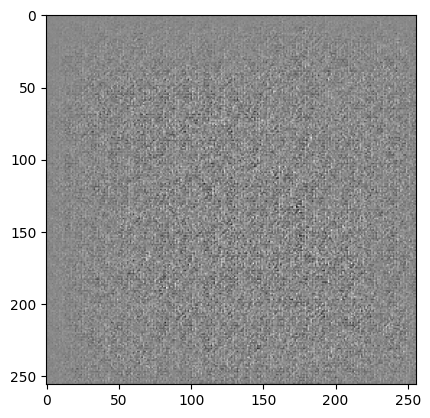

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#### Discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(8, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[6.128921e-05]], shape=(1, 1), dtype=float32)


#### Define the loss and the optimizers

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator Loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## generator Loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Define Training Loop

In [ ]:
EPOCHS = 250    ## Number of training epochs. I purposely select a high number for training epochs. We can change it as we go along
noise_dim = 100
num_examples_to_generate = 16   ## Number of images to generate. If we increase this number we have to increase epoch as well

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(25, 25))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')

    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    return predictions


def train(dataset, epochs):
    sample = []
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        samples = generate_and_save_images(generator,
                             epoch + 1,
                             seed)
        sample.append(samples[0:5])


        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
    display.clear_output(wait=True)
    generated = generate_and_save_images(generator,
                                            epochs,
                                               seed)
    return generated, np.array(sample)

### Data Preprocessing

In [ ]:
## Load Data
## These paths might be different depending on your environment and folder hierarchy
## Please make sure you have the correct paths for loading these files... 
x = pickle.load( open("/content/drive/MyDrive/MiniProject_CS5804/final/images.pickle", "rb"))
y = pickle.load( open("/content/drive/MyDrive/MiniProject_CS5804/final/labels.pickle", "rb"))

To increase dcgan generated image resolution:
- Resizing data to 256x256
- Splitting the data based on the corresponding labels
- Selecting a sample image with the best proportions and running a quick MS-SSIM comparison among the data to select most correlated images.
- I am selecting with the images have 0.5 MS-SSIM score or higher. (This MS-SSIM threshold can be changed based on the results we are getting)
- Using selected images in DCGAN to generate synthetic data.
  - This step will be repeated for each unique label.

In [ ]:
x = resize_img(x, 256, 256).astype('float32')
x = (x-0.5)/0.5

print(x.shape)
print(np.min(x))
print(np.max(x))

(3536, 256, 256)
-1.0
1.0


In [ ]:
## Seperating data based on labels
## Since this is a data for binary classification models our labels are 1.0 or 0.0
x_true = []
x_false = []
y_true = []
y_false = []
for i in range(len(y)):
    if (y[i] == 1.0):
        x_true.append(x[i])
        y_true.append(y[i])
    else:
        x_false.append(x[i])
        y_false.append(y[i])

x_true = np.array(x_true)
x_false = np.array(x_false)
y_true = np.array(y_true)
y_false = np.array(y_false)

print(x_true.shape)
print(y_true.shape)
print(x_false.shape)
print(y_false.shape)

(2571, 256, 256)
(2571,)
(965, 256, 256)
(965,)


### Image Selection for True Labels

In [ ]:
## Sample data
plt.figure(figsize=(50,50))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(x_true[i],cmap='gray')
    plt.title(f'Image Index = {i}')

Output hidden; open in https://colab.research.google.com to view.

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


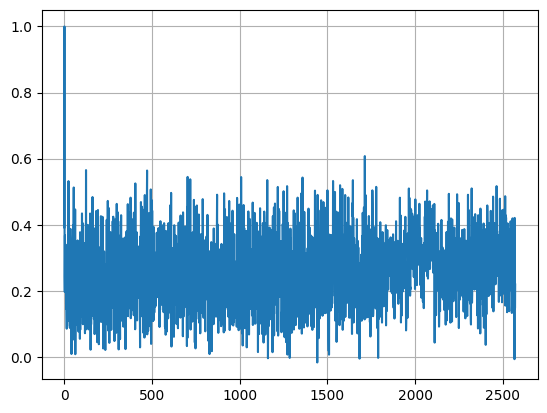

In [ ]:
## Seems like iamge at index 1 has the most repeated pattern among the true classes
sample_true = x_true[1,:,:]
## Calculating MS-SSIM scores based on the sample image
msssim_score = []
for i in range(len(x_true)):
    msssim_score.append(msssim(sample_true, x_true[i], MAX=np.max(x_true[i])))

plt.plot(msssim_score)
plt.grid('on')

In [ ]:
print(f'MAX: {np.abs(np.array(msssim_score).max())}')
print(f'MIN: {np.abs(np.array(msssim_score).min())}')

MAX: 1.0
MIN: 0.03295564019895742


In [ ]:
index_holder = []
msssim_threshold = 0.15
for i in range(len(msssim_score)):
    if (np.abs(msssim_score[i]) >= msssim_threshold):
        index_holder.append(i)
print(f'Based on the selected threshold value ({msssim_threshold}), {len(index_holder)} images can be used in DCGAN training...')

Based on the selected threshold value (0.15), 2169 images can be used in DCGAN training...


In [ ]:
## Selecting images for DCGAN training
msssim_selected = np.array(msssim_score)[index_holder]
true_selected = x_true[index_holder]
true_selected.shape

(2169, 256, 256)

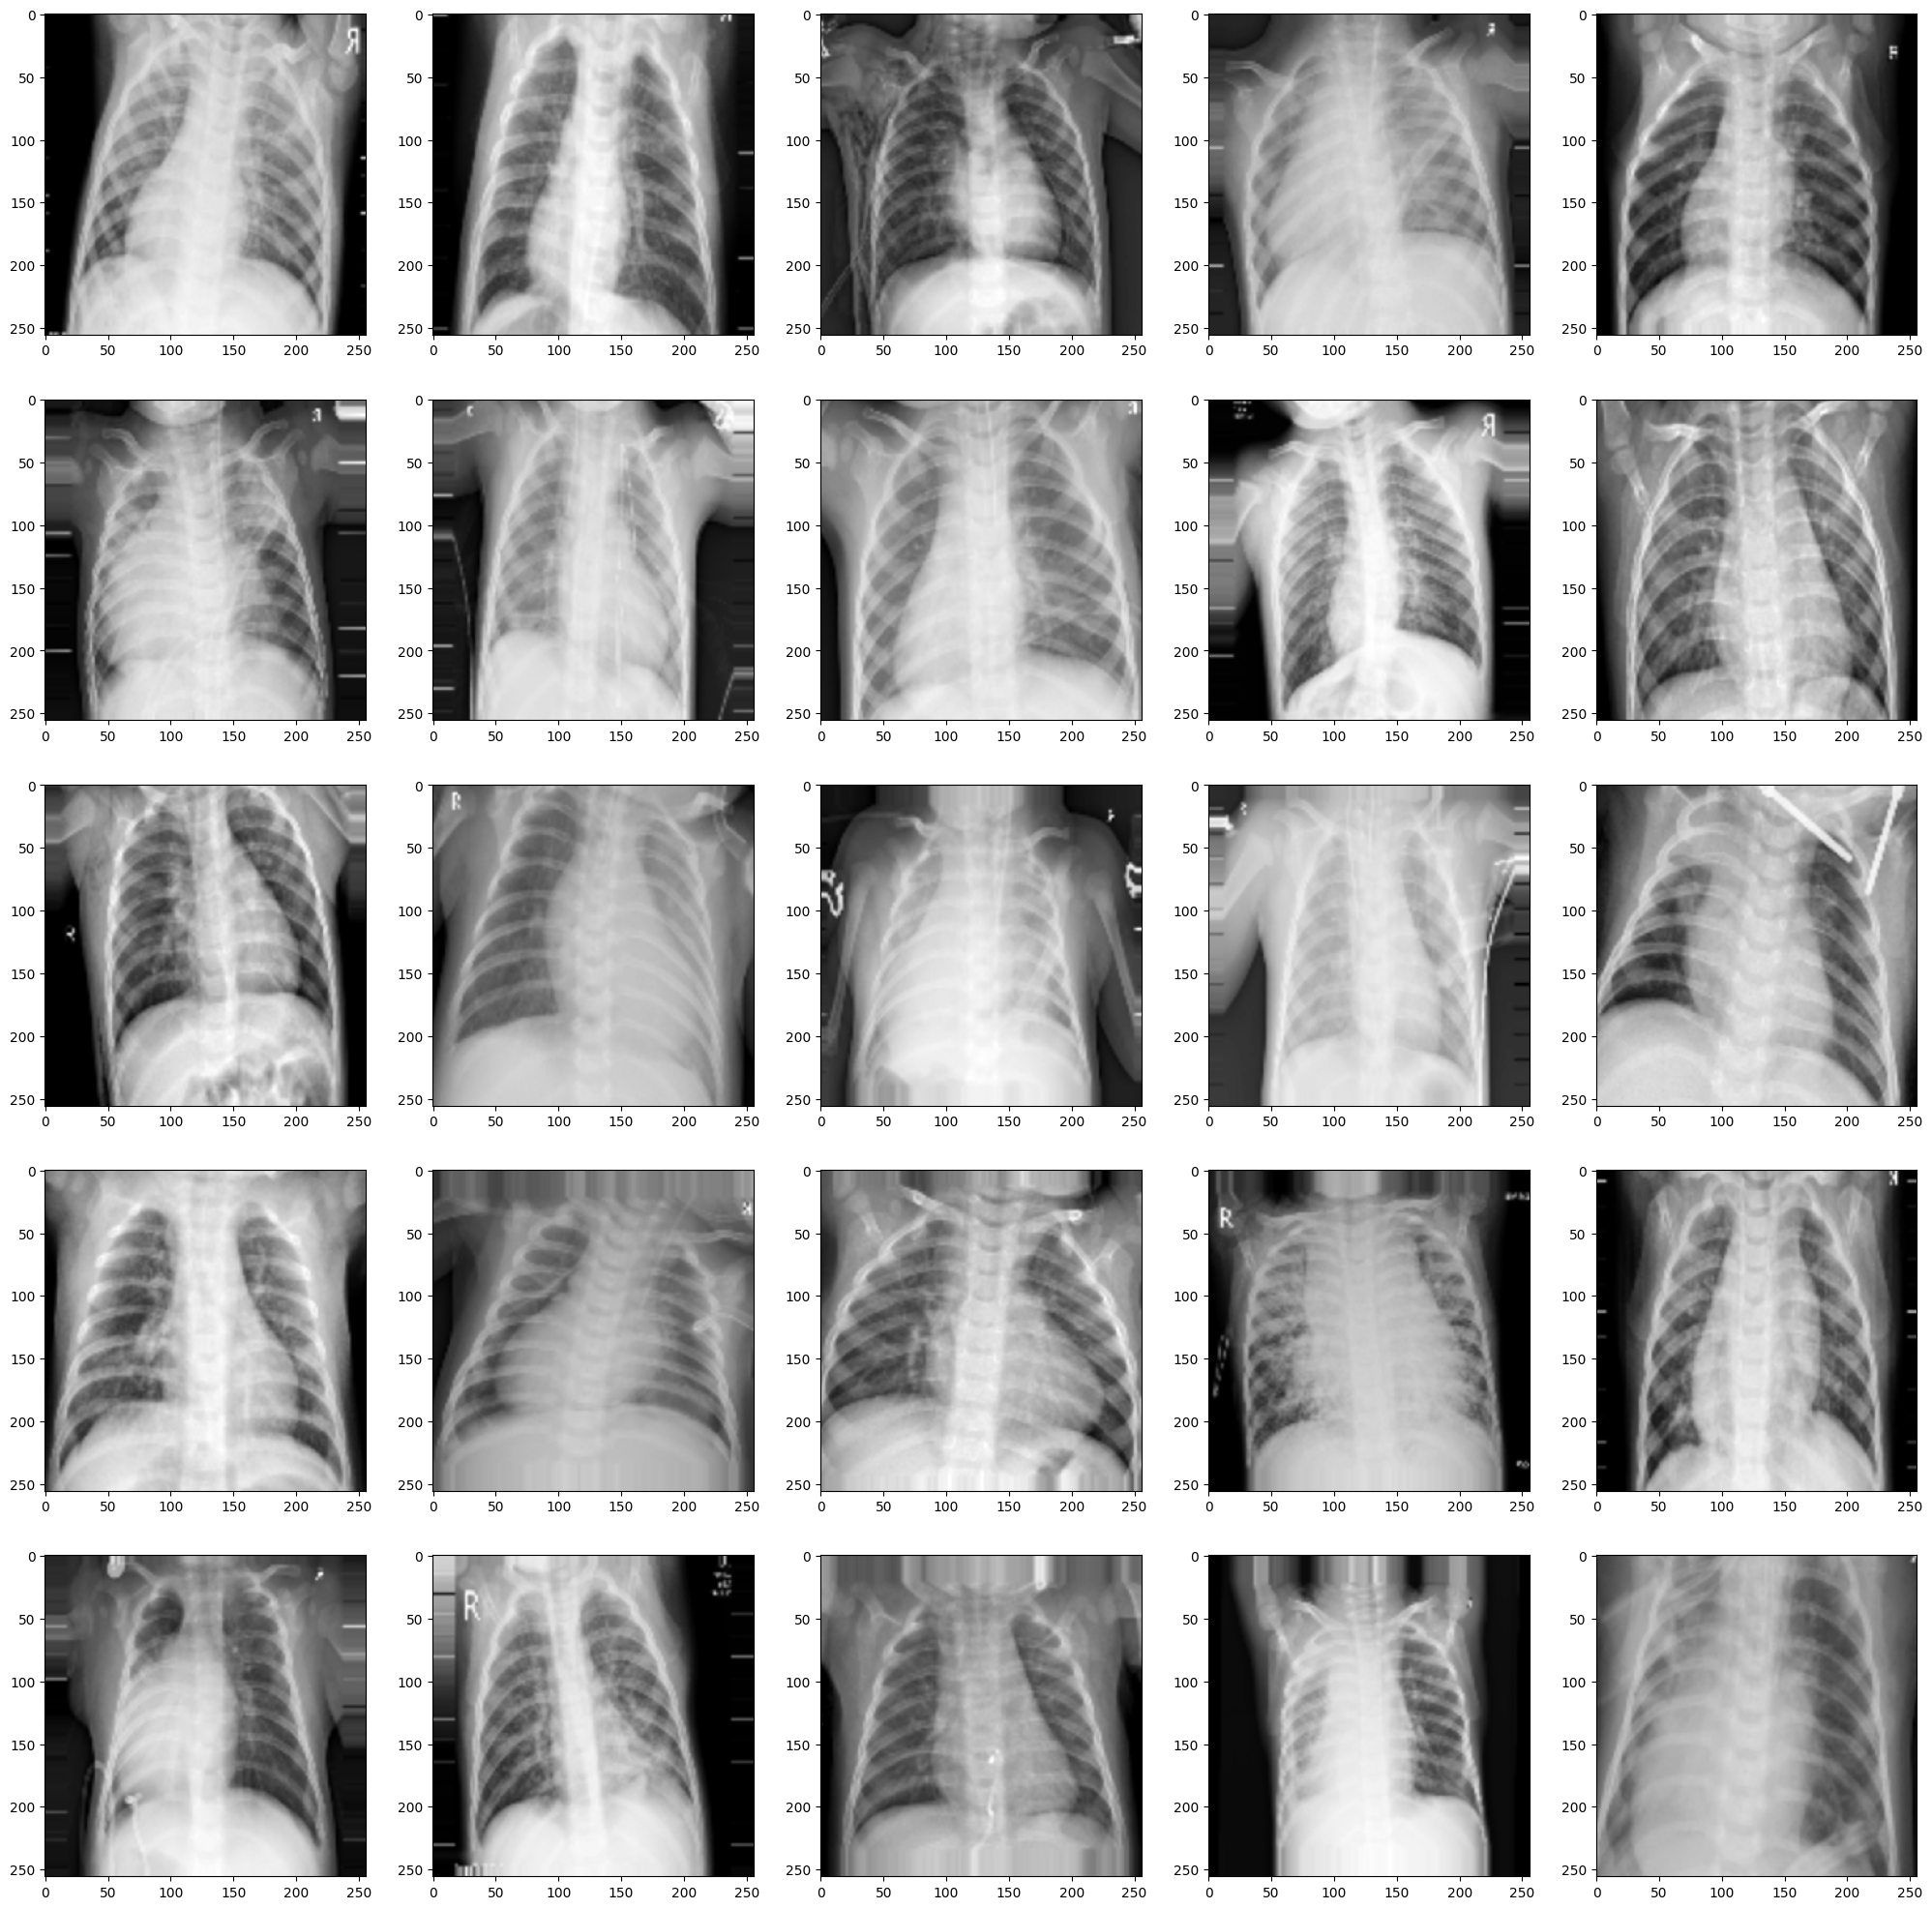

In [ ]:
## Samples from selected images
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(true_selected[i], cmap='gray')

### Model Training - True Labels

In [ ]:
## Deleting unnecessary parameter to clean RAM usage
del x,y
gc.collect()

253927

In [ ]:
BUFFER_SIZE = 4192  ## This indicated number of generated images to store in the memory during the training process
                    ## I am selecting an arbitrary number, but this can be experimented and changed for better resolution
BATCH_SIZE = 16

true_dataset = tf.data.Dataset.from_tensor_slices(true_selected).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

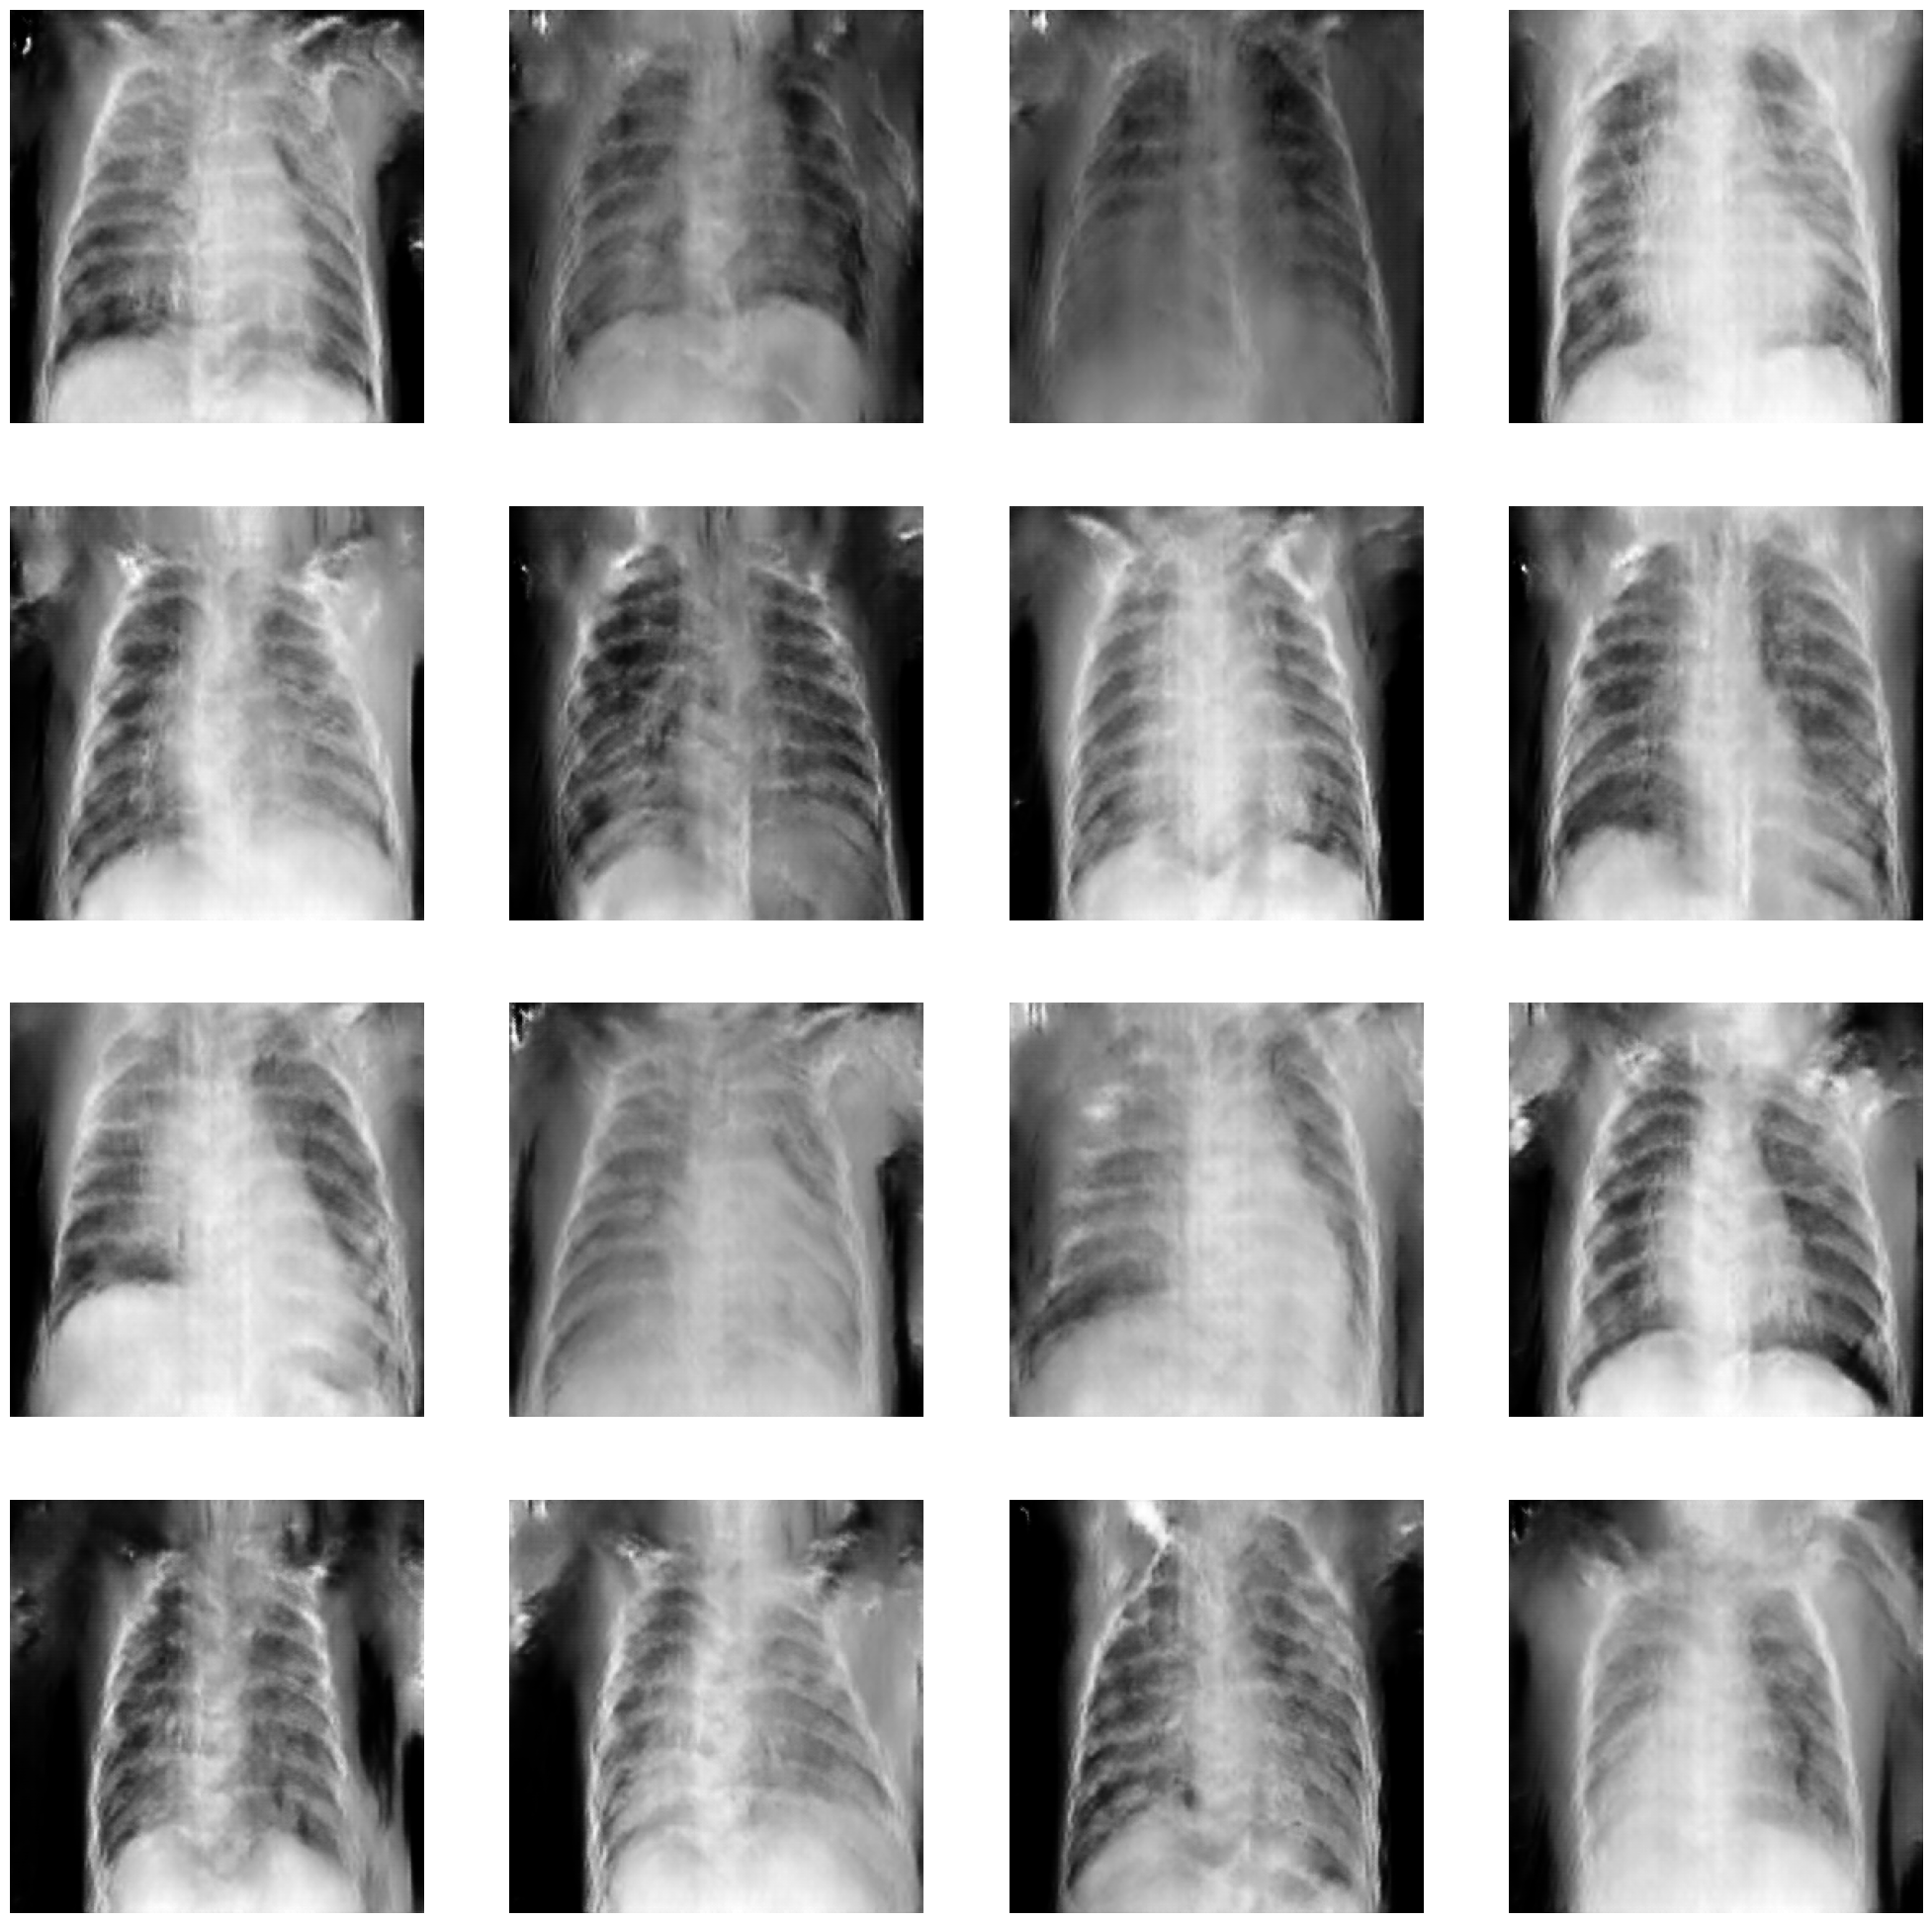

In [ ]:
EPOCHS = 800
st = time.time()
generated_true, sample_true = train(true_dataset, EPOCHS)
en = time.time()

In [ ]:
## These paths might be different depending on your environment and folder hierarchy
## Please make sure you have the correct paths for saving these files... 
pickle.dump(generated_true, open('/content/drive/MyDrive/MiniProject_CS5804/final/fake_true.pickle', 'wb'))
pickle.dump(sample_true, open('/content/drive/MyDrive/MiniProject_CS5804/final/sample_true.pickle', 'wb'))

In [ ]:
sample_true.shape

(800, 5, 256, 256, 1)

In [ ]:
## Calculating MS-SSIM scores of generated images
msssim_true = []
generated_true = np.resize(generated_true, (16,256,256))
for i in range(16):
    msssim_true.append(msssim(x_true[1,:,:], generated_true[i], MAX=np.max(generated_true[i])))

/opt/conda/lib/python3.7/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


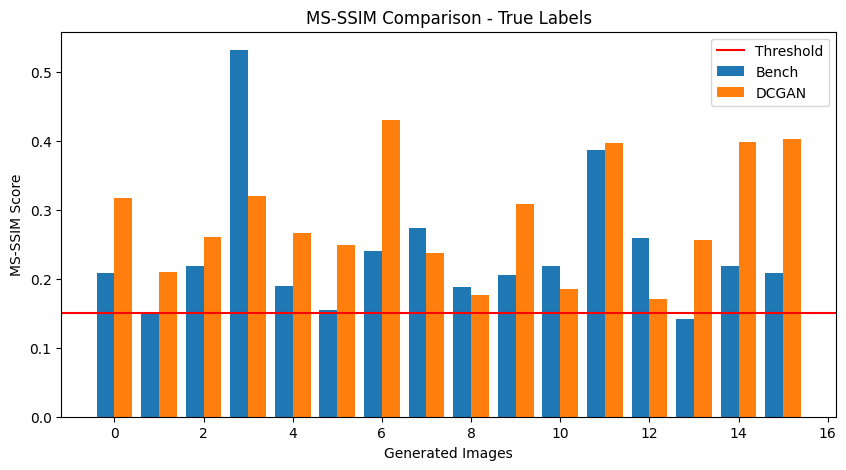

In [ ]:
msssim_generated = np.array(msssim_true)
msssim_bench = np.array(msssim_selected)[16:32]
x_ax = np.arange(16)

plt.figure(figsize=(10,5))
plt.bar(x_ax - 0.2, msssim_bench, 0.4, label = 'Bench')
plt.bar(x_ax + 0.2, msssim_generated, 0.4, label = 'DCGAN')
plt.axhline(msssim_threshold, color='red', label='Threshold')

plt.xlabel("Generated Images")
plt.ylabel("MS-SSIM Score")
plt.title("MS-SSIM Comparison - True Labels")
plt.legend()

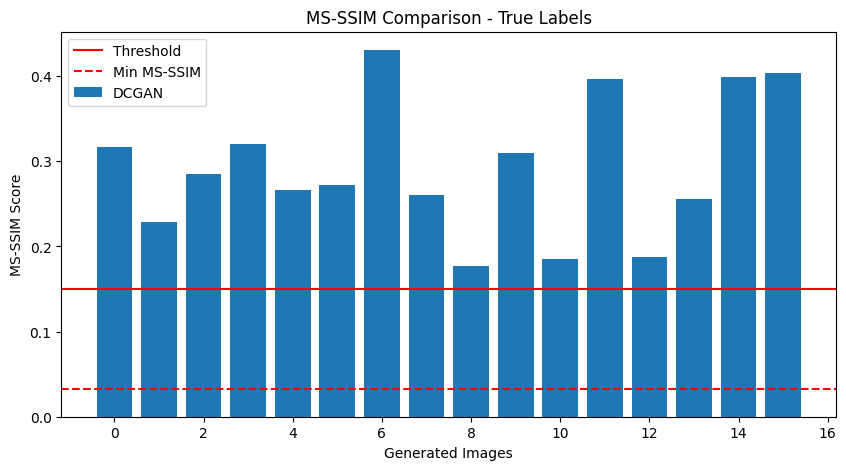

In [ ]:
msssim_generated = np.abs(np.array(msssim_true))
# msssim_bench = np.array(msssim_selected)[16:32]
x_ax = np.arange(16)

plt.figure(figsize=(10,5))
plt.bar(x_ax, msssim_generated, label = 'DCGAN')
plt.axhline(msssim_threshold, color='red', linestyle='-', label='Threshold')
plt.axhline(np.abs(np.array(msssim_score).min()), color='red', linestyle='--', label='Min MS-SSIM')

plt.xlabel("Generated Images")
plt.ylabel("MS-SSIM Score")
plt.title("MS-SSIM Comparison - True Labels")
plt.legend()
plt.savefig('/content/drive/MyDrive/MiniProject_CS5804/final/ms_ssim-true.jpeg', dpi=240)

### Image Selection for False Labels

In [ ]:
## Sample data
plt.figure(figsize=(50,50))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(x_false[i],cmap='gray')
    plt.title(f'Image Index = {i}')

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'Original Sample - False')

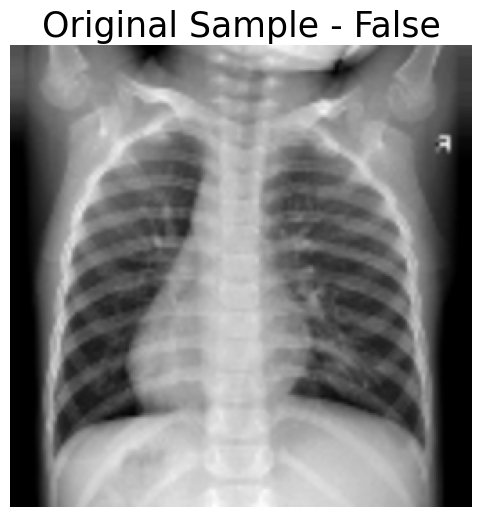

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(x_false[63], cmap='gray')
plt.axis('off')
plt.title('Original Sample - False', fontsize=25)

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


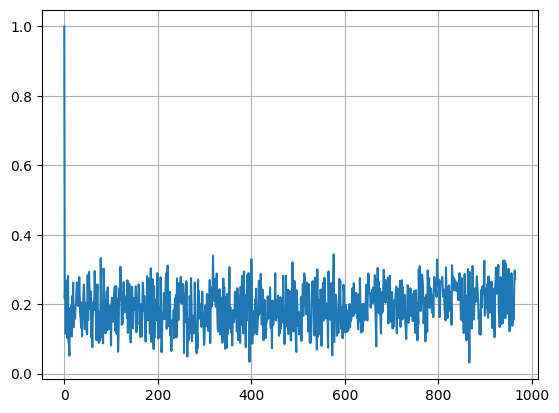

In [ ]:
## Seems like iamge at index 4 has the most repeated pattern among the true classes
sample_false = x_false[0,:,:]
## Calculating MS-SSIM scores based on the sample image
msssim_score = []
for i in range(len(x_false)):
    msssim_score.append(msssim(sample_false, x_false[i], MAX=np.max(x_false[i])))

plt.plot(msssim_score)
plt.grid('on')

In [ ]:
index_holder = []
msssim_threshold = 0.15
for i in range(len(msssim_score)):
    if (msssim_score[i] >= msssim_threshold):
        index_holder.append(i)
print(f'Based on the selected threshold value ({msssim_threshold}), {len(index_holder)} images can be used in DCGAN training...')

Based on the selected threshold value (0.15), 727 images can be used in DCGAN training...


In [ ]:
## Selecting images for DCGAN training
msssim_selected = np.array(msssim_score)[index_holder]
false_selected = x_false[index_holder]
false_selected.shape

(727, 256, 256)

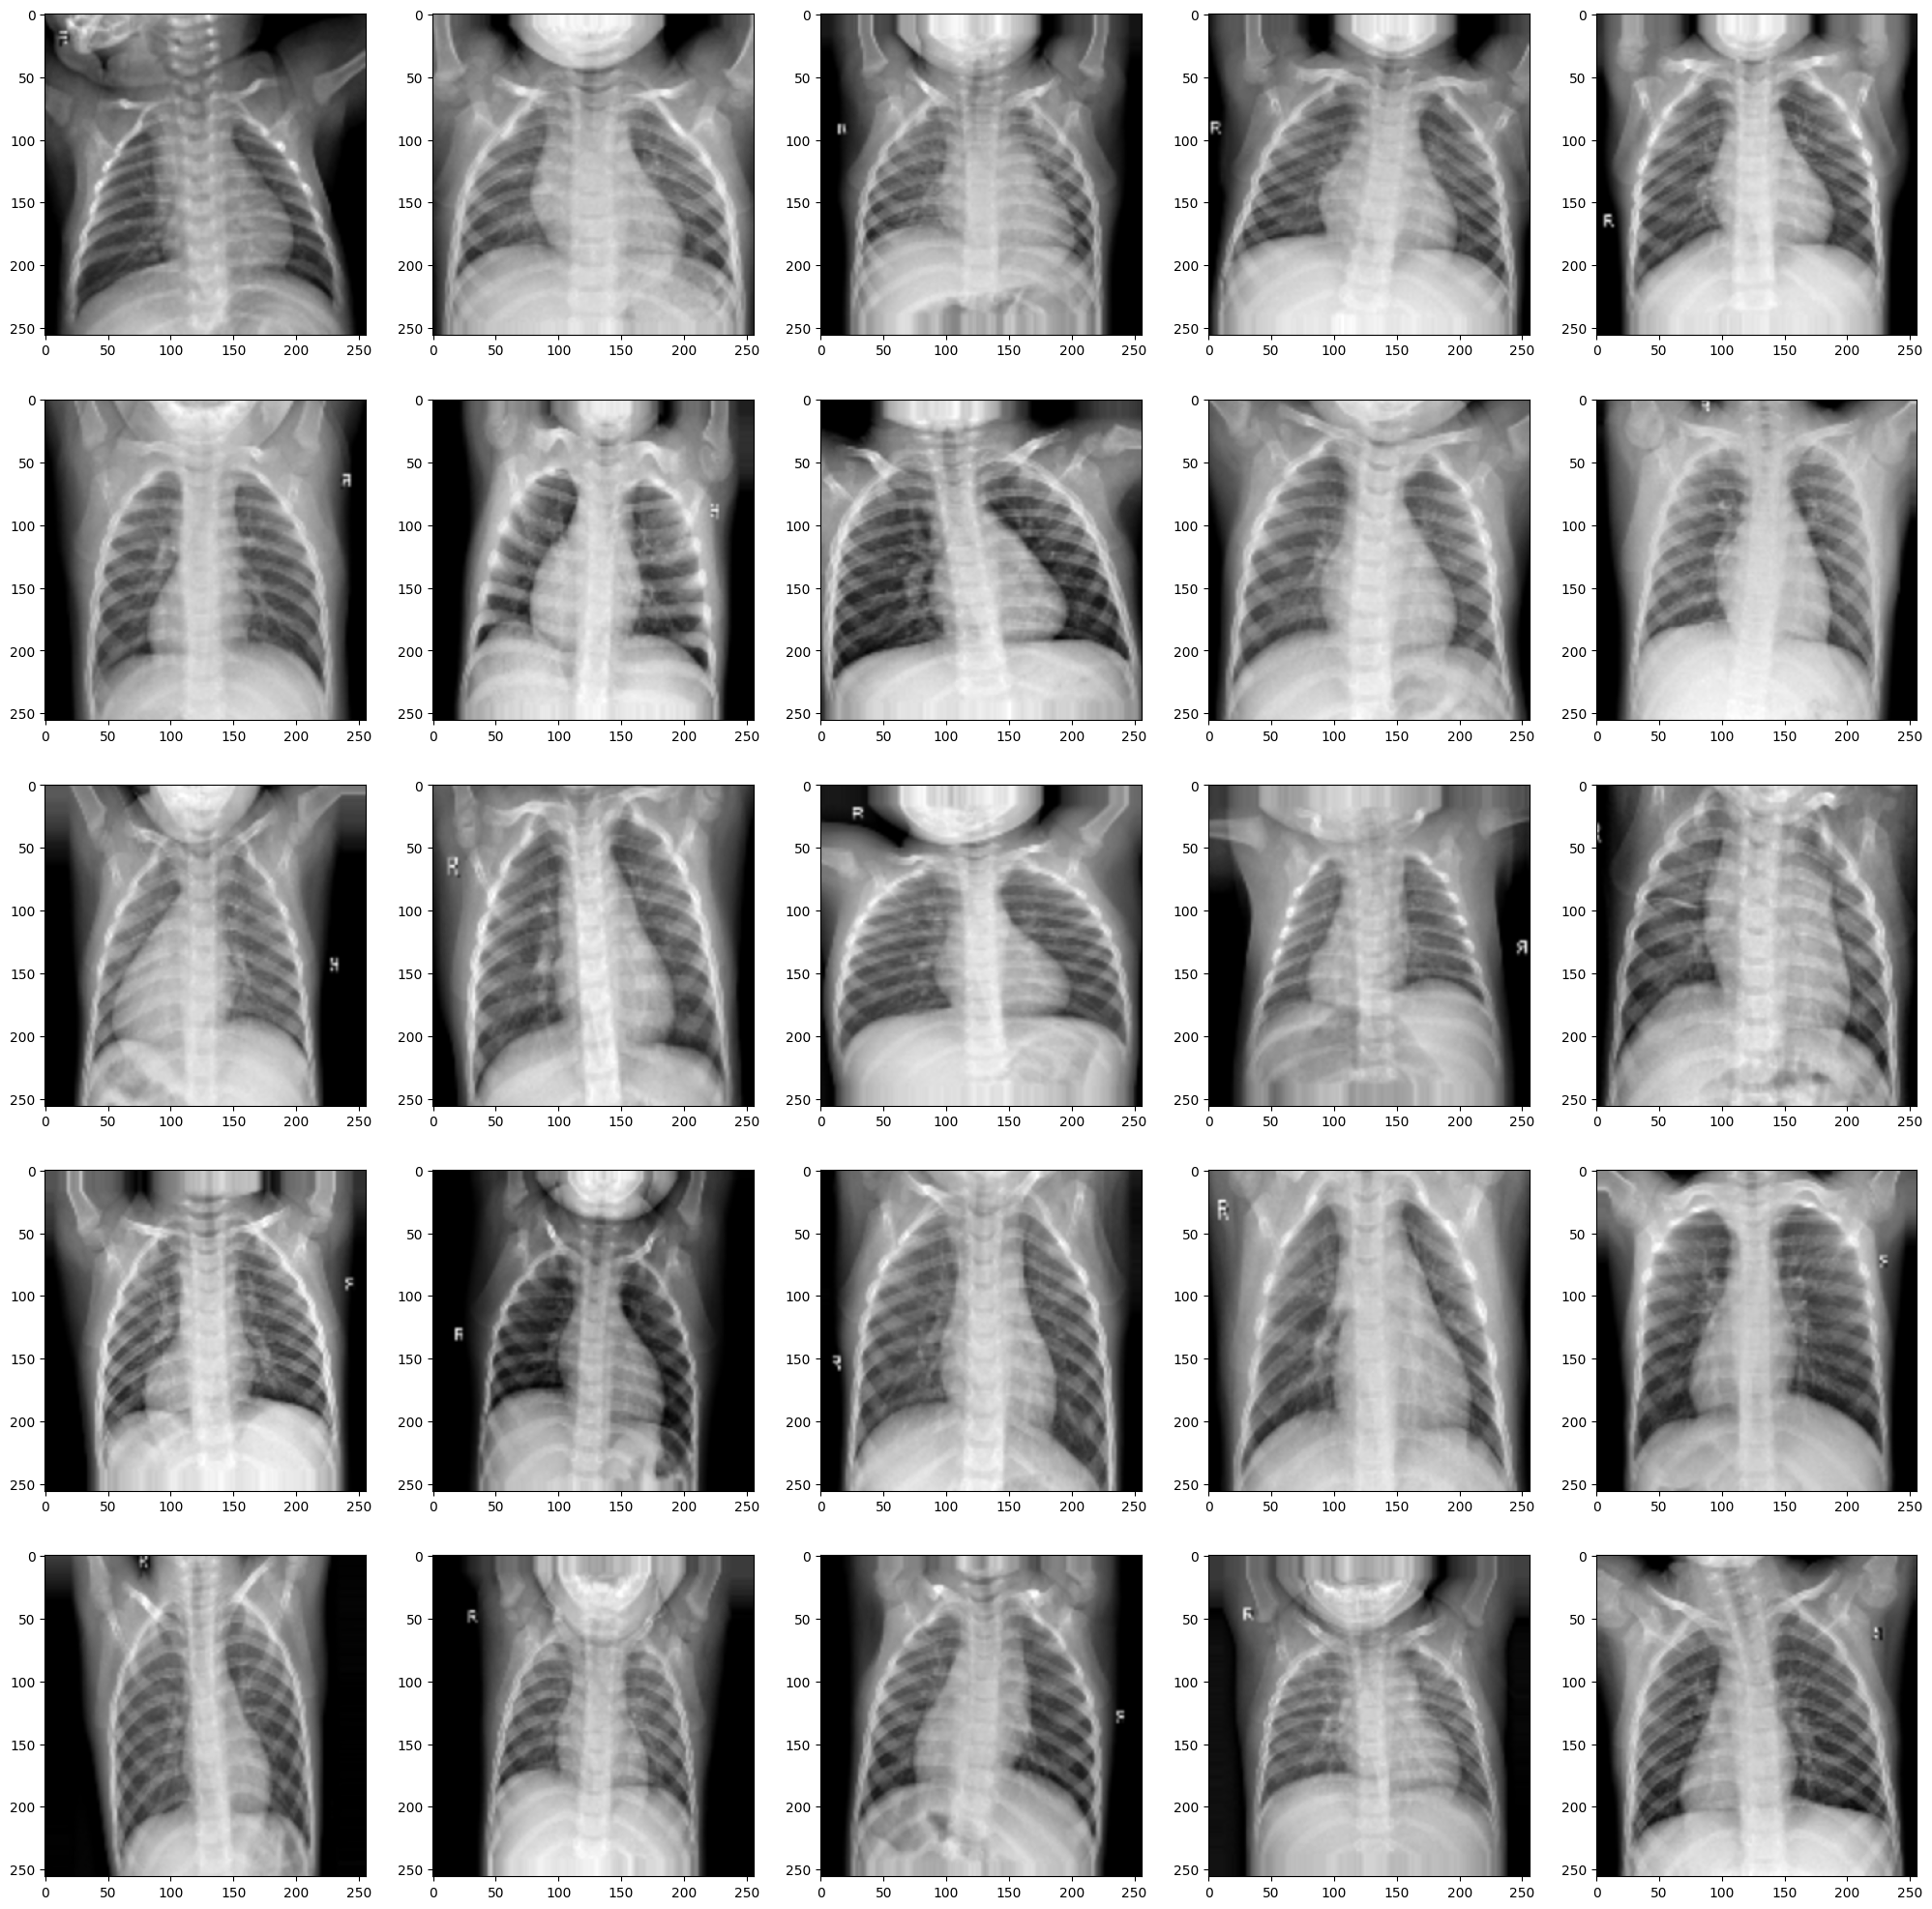

In [ ]:
## Samples from selected images
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(false_selected[i], cmap='gray')

### Model Training - False Labels

In [ ]:
BUFFER_SIZE = 4192  ## This indicated number of generated images to store in the memory during the training process
                    ## I am selecting an arbitrary number, but this can be experimented and changed for better resolution
BATCH_SIZE = 16

false_dataset = tf.data.Dataset.from_tensor_slices(false_selected).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

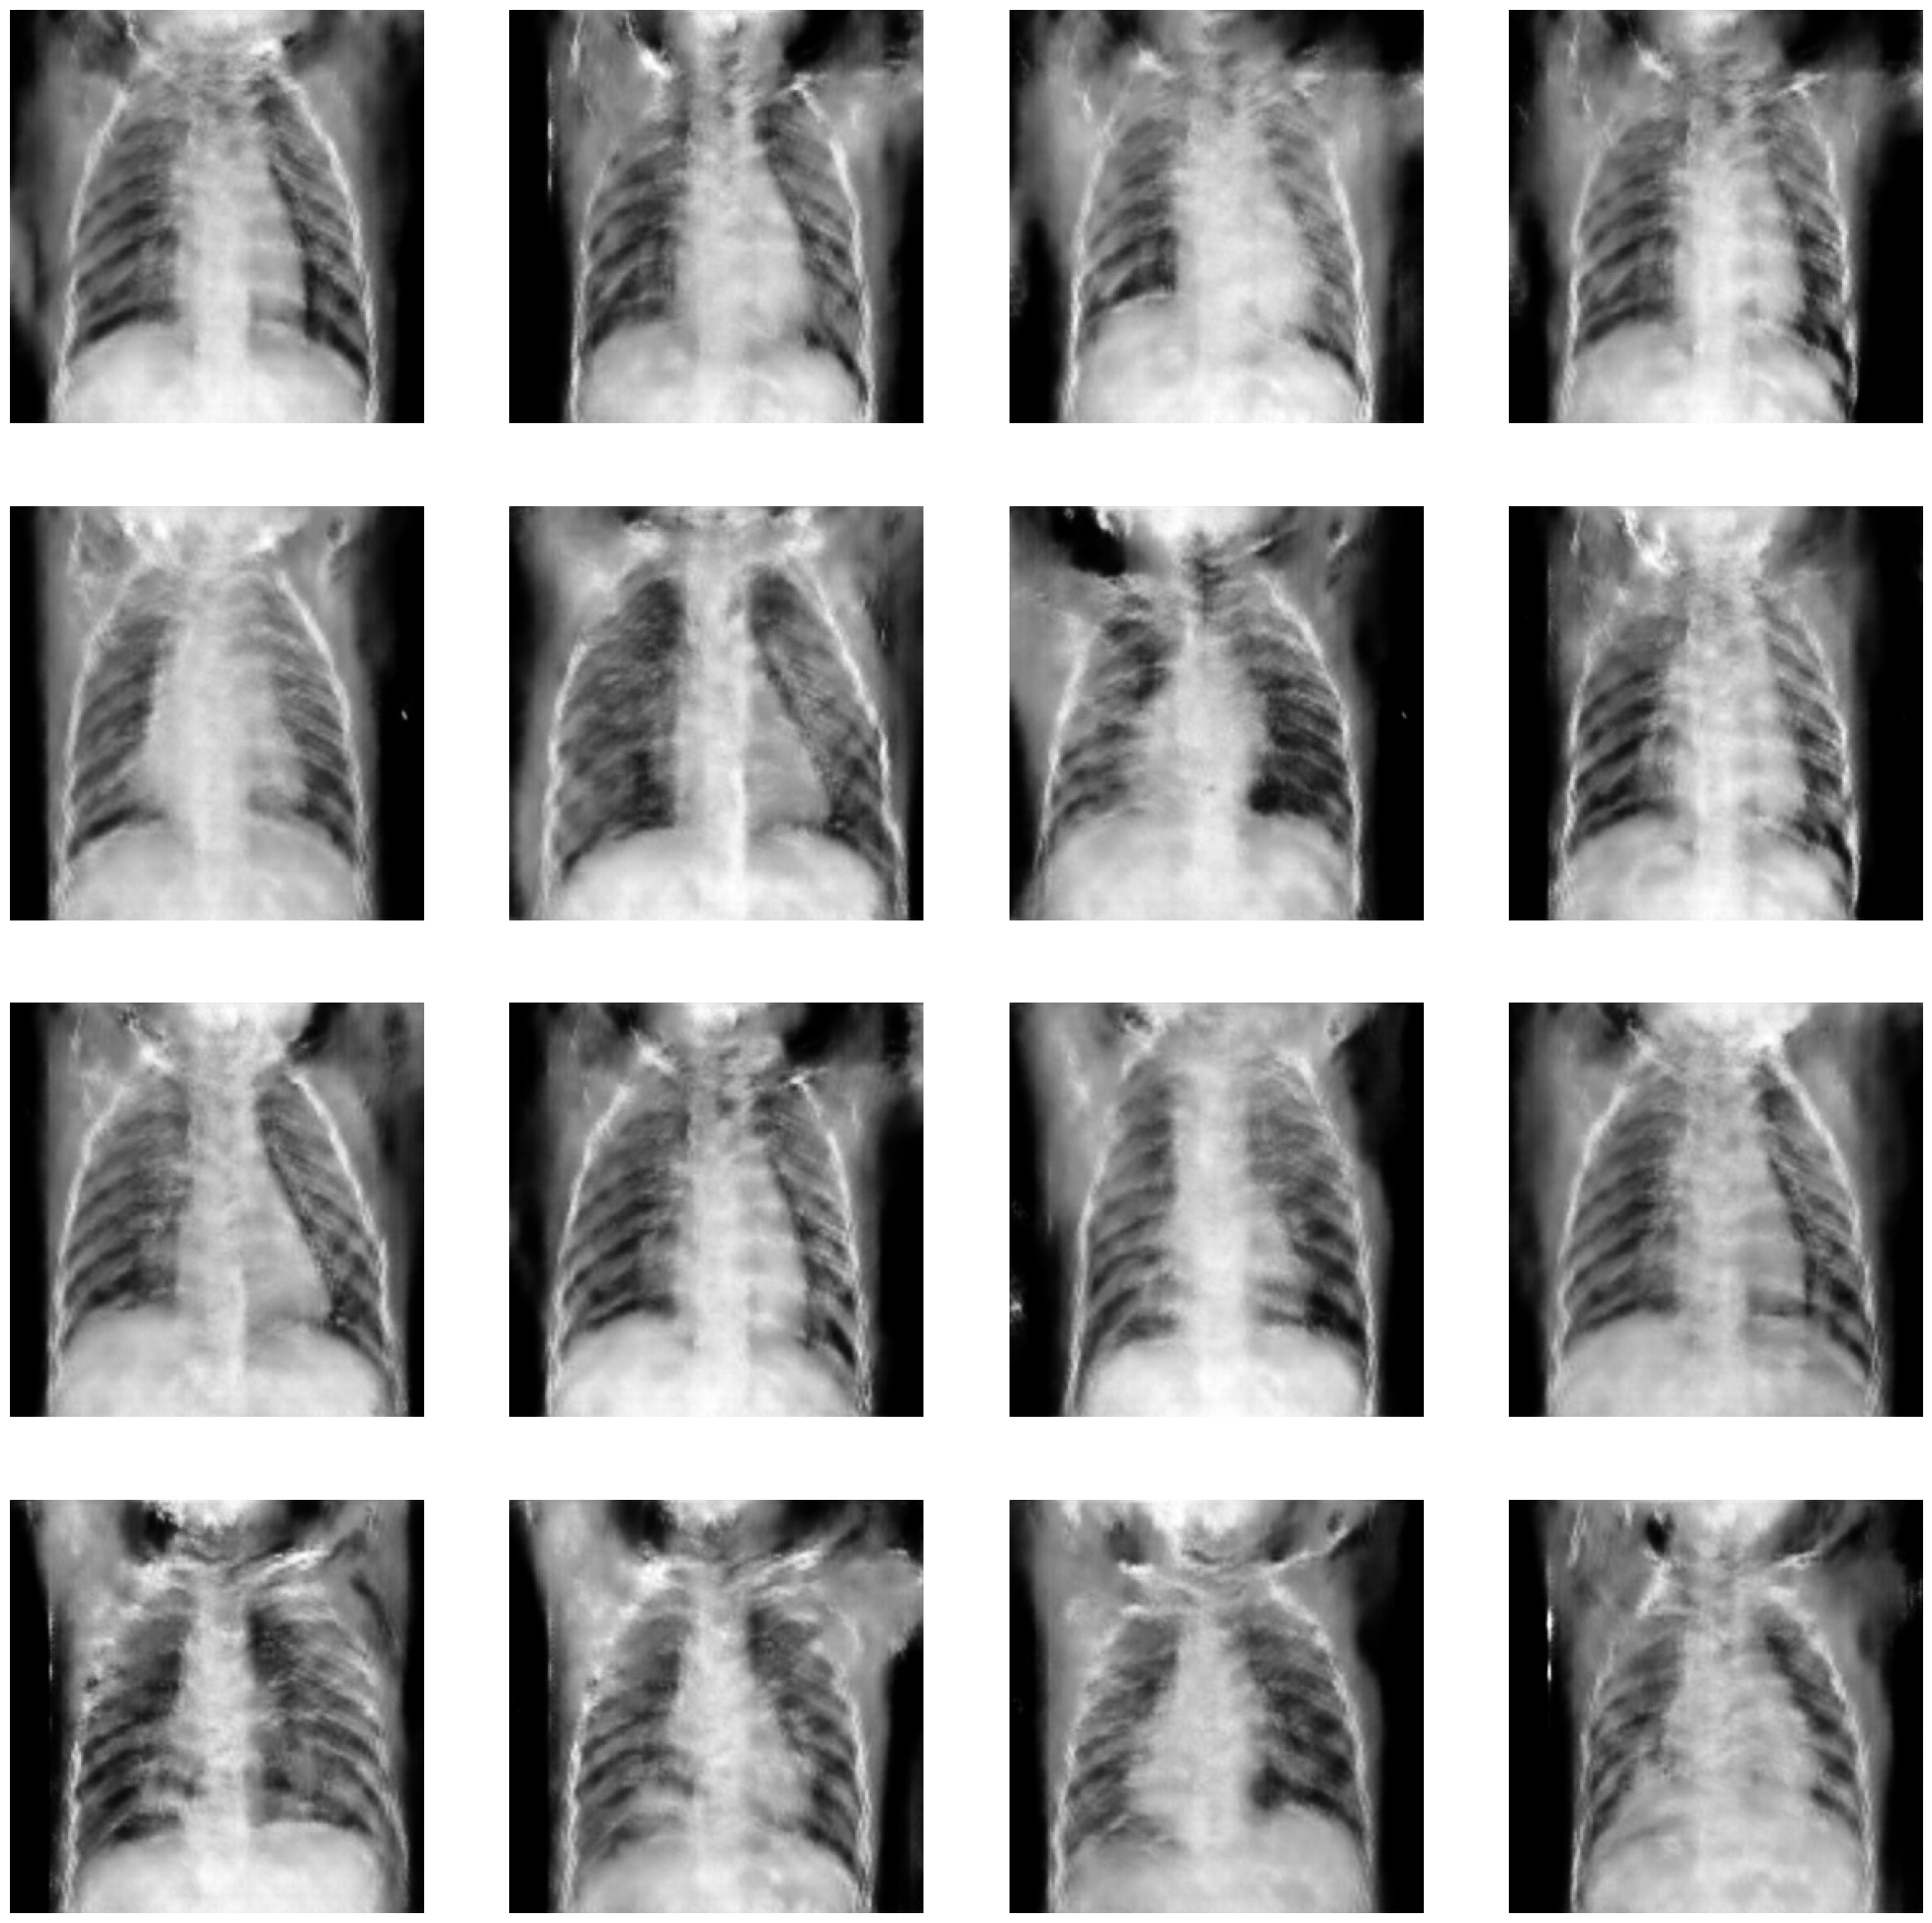

In [ ]:
EPOCHS = 800
st = time.time()
generated_false, sample_false = train(false_dataset, EPOCHS)
en = time.time()

In [ ]:
## These paths might be different depending on your environment and folder hierarchy
## Please make sure you have the correct paths for saving these files... 
pickle.dump(generated_false, open('/content/drive/MyDrive/MiniProject_CS5804/final/fake_false.pickle', 'wb'))
pickle.dump(sample_false, open('/content/drive/MyDrive/MiniProject_CS5804/final/sample_false.pickle', 'wb'))

In [ ]:
## Calculating MS-SSIM scores of generated images
msssim_false = []
generated_false = np.resize(generated_false, (16,256,256))
for i in range(16):
    msssim_false.append(msssim(x_false[0,:,:], generated_false[i], MAX=np.max(generated_false[i])))

/opt/conda/lib/python3.7/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


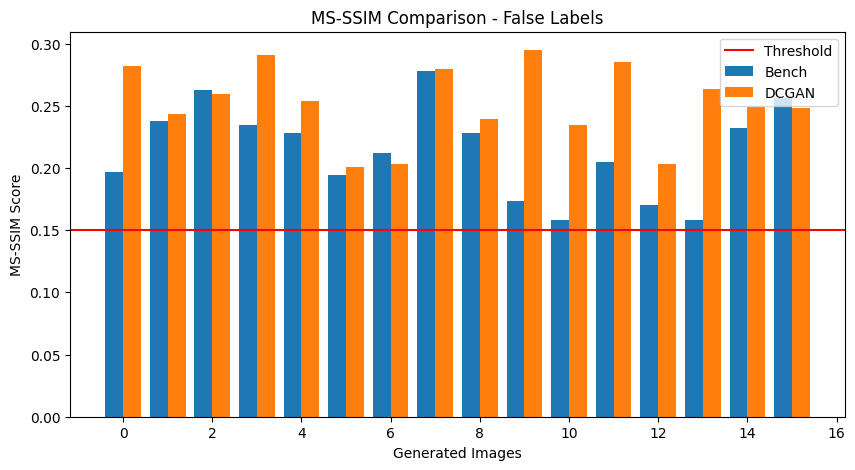

In [ ]:
msssim_generated = np.array(msssim_false)
msssim_bench = np.array(msssim_selected)[16:32]
x_ax = np.arange(16)

plt.figure(figsize=(10,5))
plt.bar(x_ax - 0.2, msssim_bench, 0.4, label = 'Bench')
plt.bar(x_ax + 0.2, msssim_generated, 0.4, label = 'DCGAN')
plt.axhline(msssim_threshold, color='red', label='Threshold')

plt.xlabel("Generated Images")
plt.ylabel("MS-SSIM Score")
plt.title("MS-SSIM Comparison - False Labels")
plt.legend()

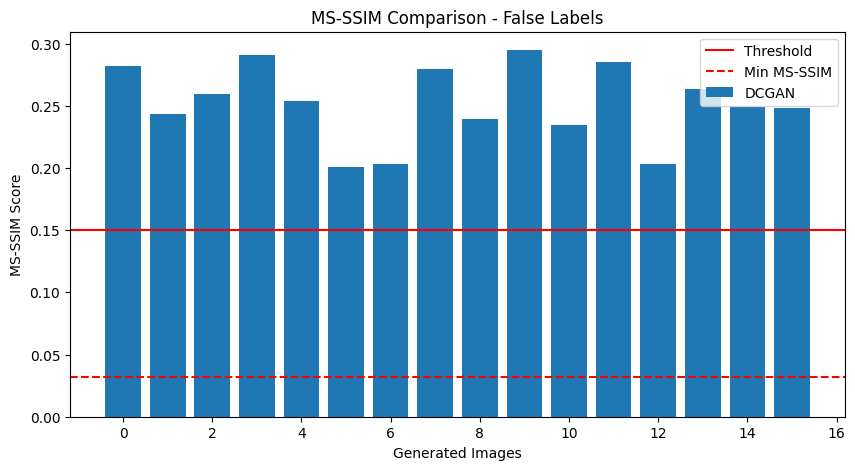

In [ ]:
msssim_generated = np.abs(np.array(msssim_false))
# msssim_bench = np.array(msssim_selected)[16:32]
x_ax = np.arange(16)

plt.figure(figsize=(10,5))
plt.bar(x_ax, msssim_generated, label = 'DCGAN')
plt.axhline(msssim_threshold, color='red', linestyle='-', label='Threshold')
plt.axhline(np.abs(np.array(msssim_score).min()), color='red', linestyle='--', label='Min MS-SSIM')

plt.xlabel("Generated Images")
plt.ylabel("MS-SSIM Score")
plt.title("MS-SSIM Comparison - False Labels")
plt.legend()
plt.savefig('/content/drive/MyDrive/MiniProject_CS5804/final/ms_ssim-false.jpeg', dpi=240)